### Train a ResNet18 on cifar10

In [1]:
import torch
import torchvision
import torchvision.transforms as tt
import torch.optim as optim

import tqdm

from captum.attr import Saliency
import matplotlib.pyplot as plt

/home/sbordt/anaconda3/envs/deeplearning/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### We perform the same data pre-processing as when training the diffusion models: scale images to the range [-1,1]

In [3]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_transform = tt.Compose(
    [tt.RandomCrop(32, padding=4),
     tt.RandomHorizontalFlip(),
     tt.ToTensor(),
     tt.Normalize(*stats,inplace=True)])

test_transform = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
images = iter(trainloader).__next__()[0]
images.min(), images.max()

(tensor(-1.), tensor(1.))

In [5]:
model = torchvision.models.resnet18(num_classes=10)
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

In [43]:
#optimizer = optim.Adam(model.parameters(), lr=1e-4)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [6]:
def test(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct // total} %')

In [46]:
for epoch in range(200):  # loop over the dataset multiple times

    model.train()
    running_loss = 0.0
    for i, data in tqdm.tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1} avg. loss per batch: {running_loss / len(trainloader):.3f}')
    running_loss = 0.0

    test(model)
    
    scheduler.step()


391it [00:06, 64.91it/s]

[1 avg. loss per batch: 2.024


Test Accuracy: 43 %


391it [00:05, 68.88it/s]

[2 avg. loss per batch: 1.485


Test Accuracy: 51 %


391it [00:05, 67.60it/s]

[3 avg. loss per batch: 1.285


Test Accuracy: 55 %


391it [00:05, 69.02it/s]

[4 avg. loss per batch: 1.145


Test Accuracy: 59 %


391it [00:05, 71.02it/s]

[5 avg. loss per batch: 1.057


Test Accuracy: 63 %


391it [00:05, 71.56it/s]

[6 avg. loss per batch: 0.992


Test Accuracy: 66 %


391it [00:05, 70.36it/s]

[7 avg. loss per batch: 0.939


Test Accuracy: 69 %


391it [00:05, 70.95it/s]

[8 avg. loss per batch: 0.895


Test Accuracy: 69 %


391it [00:05, 68.79it/s]

[9 avg. loss per batch: 0.872


Test Accuracy: 67 %


391it [00:05, 69.00it/s]

[10 avg. loss per batch: 0.845


Test Accuracy: 67 %


391it [00:05, 70.26it/s]

[11 avg. loss per batch: 0.823


Test Accuracy: 68 %


391it [00:05, 66.72it/s]

[12 avg. loss per batch: 0.802


Test Accuracy: 71 %


391it [00:05, 66.04it/s]

[13 avg. loss per batch: 0.795


Test Accuracy: 71 %


391it [00:05, 69.74it/s]

[14 avg. loss per batch: 0.779


Test Accuracy: 68 %


391it [00:05, 69.37it/s]

[15 avg. loss per batch: 0.772


Test Accuracy: 70 %


391it [00:05, 68.87it/s]

[16 avg. loss per batch: 0.754


Test Accuracy: 71 %


391it [00:05, 69.81it/s]

[17 avg. loss per batch: 0.747


Test Accuracy: 72 %


391it [00:05, 70.25it/s]

[18 avg. loss per batch: 0.747


Test Accuracy: 74 %


391it [00:05, 69.26it/s]

[19 avg. loss per batch: 0.732


Test Accuracy: 70 %


391it [00:05, 71.72it/s]

[20 avg. loss per batch: 0.730


Test Accuracy: 69 %


391it [00:05, 68.30it/s]

[21 avg. loss per batch: 0.724


Test Accuracy: 71 %


391it [00:05, 68.68it/s]

[22 avg. loss per batch: 0.716


Test Accuracy: 72 %


391it [00:05, 68.53it/s]

[23 avg. loss per batch: 0.707


Test Accuracy: 72 %


391it [00:05, 69.60it/s]

[24 avg. loss per batch: 0.705


Test Accuracy: 76 %


391it [00:05, 66.23it/s]

[25 avg. loss per batch: 0.704


Test Accuracy: 72 %


391it [00:06, 58.65it/s]

[26 avg. loss per batch: 0.691


Test Accuracy: 73 %


391it [00:05, 65.59it/s]

[27 avg. loss per batch: 0.689


Test Accuracy: 73 %


391it [00:05, 65.96it/s]

[28 avg. loss per batch: 0.683


Test Accuracy: 75 %


391it [00:05, 70.69it/s]

[29 avg. loss per batch: 0.687


Test Accuracy: 74 %


391it [00:05, 70.38it/s]

[30 avg. loss per batch: 0.685


Test Accuracy: 75 %


391it [00:05, 70.17it/s]

[31 avg. loss per batch: 0.679


Test Accuracy: 74 %


391it [00:05, 68.30it/s]

[32 avg. loss per batch: 0.676


Test Accuracy: 73 %


391it [00:05, 67.86it/s]

[33 avg. loss per batch: 0.678


Test Accuracy: 73 %


391it [00:05, 70.21it/s]

[34 avg. loss per batch: 0.665


Test Accuracy: 76 %


391it [00:05, 69.67it/s]

[35 avg. loss per batch: 0.660


Test Accuracy: 74 %


391it [00:05, 67.74it/s]

[36 avg. loss per batch: 0.663


Test Accuracy: 76 %


391it [00:05, 69.45it/s]

[37 avg. loss per batch: 0.659


Test Accuracy: 75 %


391it [00:05, 68.98it/s]

[38 avg. loss per batch: 0.653


Test Accuracy: 76 %


391it [00:05, 66.91it/s]

[39 avg. loss per batch: 0.649


Test Accuracy: 75 %


391it [00:05, 67.16it/s]

[40 avg. loss per batch: 0.654


Test Accuracy: 76 %


391it [00:05, 67.20it/s]

[41 avg. loss per batch: 0.643


Test Accuracy: 76 %


391it [00:05, 67.30it/s]

[42 avg. loss per batch: 0.646


Test Accuracy: 74 %


391it [00:05, 65.86it/s]

[43 avg. loss per batch: 0.637


Test Accuracy: 76 %


391it [00:05, 65.73it/s]

[44 avg. loss per batch: 0.646


Test Accuracy: 76 %


391it [00:05, 65.27it/s]

[45 avg. loss per batch: 0.640


Test Accuracy: 76 %


391it [00:06, 64.02it/s]

[46 avg. loss per batch: 0.635


Test Accuracy: 74 %


391it [00:05, 66.20it/s]

[47 avg. loss per batch: 0.627


Test Accuracy: 74 %


391it [00:05, 66.59it/s]

[48 avg. loss per batch: 0.632


Test Accuracy: 76 %


391it [00:05, 67.02it/s]

[49 avg. loss per batch: 0.627


Test Accuracy: 74 %


391it [00:05, 67.38it/s]

[50 avg. loss per batch: 0.626


Test Accuracy: 71 %


391it [00:05, 67.10it/s]

[51 avg. loss per batch: 0.618


Test Accuracy: 75 %


391it [00:05, 66.00it/s]

[52 avg. loss per batch: 0.617


Test Accuracy: 75 %


391it [00:05, 66.53it/s]

[53 avg. loss per batch: 0.618


Test Accuracy: 75 %


391it [00:05, 66.91it/s]

[54 avg. loss per batch: 0.617


Test Accuracy: 78 %


391it [00:05, 68.13it/s]

[55 avg. loss per batch: 0.620


Test Accuracy: 75 %


391it [00:05, 68.67it/s]

[56 avg. loss per batch: 0.606


Test Accuracy: 76 %


391it [00:05, 68.43it/s]

[57 avg. loss per batch: 0.609


Test Accuracy: 78 %


391it [00:05, 68.18it/s]

[58 avg. loss per batch: 0.607


Test Accuracy: 74 %


391it [00:05, 67.09it/s]

[59 avg. loss per batch: 0.609


Test Accuracy: 76 %


391it [00:05, 65.84it/s]

[60 avg. loss per batch: 0.601


Test Accuracy: 75 %


391it [00:05, 67.32it/s]

[61 avg. loss per batch: 0.601


Test Accuracy: 77 %


391it [00:05, 68.11it/s]

[62 avg. loss per batch: 0.599


Test Accuracy: 74 %


391it [00:05, 66.71it/s]

[63 avg. loss per batch: 0.593


Test Accuracy: 78 %


391it [00:06, 64.53it/s]

[64 avg. loss per batch: 0.594


Test Accuracy: 76 %


391it [00:05, 66.54it/s]

[65 avg. loss per batch: 0.589


Test Accuracy: 78 %


391it [00:05, 67.39it/s]

[66 avg. loss per batch: 0.592


Test Accuracy: 78 %


391it [00:05, 67.70it/s]

[67 avg. loss per batch: 0.582


Test Accuracy: 78 %


391it [00:05, 66.75it/s]

[68 avg. loss per batch: 0.584


Test Accuracy: 75 %


391it [00:05, 68.31it/s]

[69 avg. loss per batch: 0.579


Test Accuracy: 77 %


391it [00:05, 67.93it/s]

[70 avg. loss per batch: 0.573


Test Accuracy: 78 %


391it [00:06, 64.17it/s]

[71 avg. loss per batch: 0.573


Test Accuracy: 78 %


391it [00:06, 65.05it/s]

[72 avg. loss per batch: 0.574


Test Accuracy: 79 %


391it [00:06, 63.70it/s]

[73 avg. loss per batch: 0.569


Test Accuracy: 76 %


391it [00:05, 68.25it/s]

[74 avg. loss per batch: 0.567


Test Accuracy: 78 %


391it [00:05, 67.16it/s]

[75 avg. loss per batch: 0.566


Test Accuracy: 76 %


391it [00:05, 65.37it/s]

[76 avg. loss per batch: 0.564


Test Accuracy: 75 %


391it [00:05, 66.96it/s]

[77 avg. loss per batch: 0.558


Test Accuracy: 78 %


391it [00:05, 70.30it/s]

[78 avg. loss per batch: 0.555


Test Accuracy: 78 %


391it [00:05, 66.62it/s]

[79 avg. loss per batch: 0.556


Test Accuracy: 77 %


391it [00:05, 67.70it/s]

[80 avg. loss per batch: 0.552


Test Accuracy: 78 %


391it [00:05, 69.82it/s]

[81 avg. loss per batch: 0.547


Test Accuracy: 78 %


391it [00:05, 67.24it/s]

[82 avg. loss per batch: 0.543


Test Accuracy: 78 %


391it [00:05, 65.93it/s]

[83 avg. loss per batch: 0.540


Test Accuracy: 79 %


391it [00:05, 66.90it/s]

[84 avg. loss per batch: 0.538


Test Accuracy: 80 %


391it [00:05, 67.85it/s]

[85 avg. loss per batch: 0.532


Test Accuracy: 79 %


391it [00:05, 67.21it/s]

[86 avg. loss per batch: 0.529


Test Accuracy: 77 %


391it [00:05, 69.05it/s]

[87 avg. loss per batch: 0.535


Test Accuracy: 79 %


391it [00:05, 69.07it/s]

[88 avg. loss per batch: 0.519


Test Accuracy: 79 %


391it [00:05, 70.23it/s]

[89 avg. loss per batch: 0.521


Test Accuracy: 77 %


391it [00:05, 70.76it/s]

[90 avg. loss per batch: 0.519


Test Accuracy: 79 %


391it [00:05, 68.58it/s]

[91 avg. loss per batch: 0.516


Test Accuracy: 79 %


391it [00:05, 69.20it/s]

[92 avg. loss per batch: 0.513


Test Accuracy: 79 %


391it [00:05, 68.97it/s]

[93 avg. loss per batch: 0.515


Test Accuracy: 79 %


391it [00:05, 70.41it/s]

[94 avg. loss per batch: 0.508


Test Accuracy: 79 %


391it [00:05, 73.59it/s]

[95 avg. loss per batch: 0.505


Test Accuracy: 80 %


391it [00:05, 71.37it/s]

[96 avg. loss per batch: 0.501


Test Accuracy: 79 %


391it [00:05, 71.66it/s]

[97 avg. loss per batch: 0.491


Test Accuracy: 80 %


391it [00:05, 71.35it/s]

[98 avg. loss per batch: 0.496


Test Accuracy: 78 %


391it [00:05, 69.90it/s]

[99 avg. loss per batch: 0.487


Test Accuracy: 80 %


391it [00:05, 71.49it/s]

[100 avg. loss per batch: 0.487


Test Accuracy: 80 %


391it [00:05, 71.01it/s]

[101 avg. loss per batch: 0.488


Test Accuracy: 78 %


391it [00:05, 73.37it/s]

[102 avg. loss per batch: 0.476


Test Accuracy: 80 %


391it [00:05, 68.56it/s]

[103 avg. loss per batch: 0.482


Test Accuracy: 80 %


391it [00:05, 69.27it/s]

[104 avg. loss per batch: 0.470


Test Accuracy: 81 %


391it [00:05, 69.24it/s]

[105 avg. loss per batch: 0.468


Test Accuracy: 79 %


391it [00:05, 68.53it/s]

[106 avg. loss per batch: 0.468


Test Accuracy: 80 %


391it [00:05, 68.61it/s]

[107 avg. loss per batch: 0.459


Test Accuracy: 80 %


391it [00:05, 70.44it/s]

[108 avg. loss per batch: 0.457


Test Accuracy: 80 %


391it [00:05, 68.30it/s]

[109 avg. loss per batch: 0.451


Test Accuracy: 80 %


391it [00:05, 69.62it/s]

[110 avg. loss per batch: 0.445


Test Accuracy: 80 %


391it [00:05, 69.40it/s]

[111 avg. loss per batch: 0.444


Test Accuracy: 81 %


391it [00:05, 69.63it/s]

[112 avg. loss per batch: 0.435


Test Accuracy: 81 %


391it [00:05, 69.52it/s]

[113 avg. loss per batch: 0.440


Test Accuracy: 80 %


391it [00:05, 69.32it/s]

[114 avg. loss per batch: 0.432


Test Accuracy: 80 %


391it [00:05, 69.00it/s]

[115 avg. loss per batch: 0.430


Test Accuracy: 82 %


391it [00:05, 70.01it/s]

[116 avg. loss per batch: 0.428


Test Accuracy: 83 %


391it [00:05, 70.39it/s]

[117 avg. loss per batch: 0.420


Test Accuracy: 82 %


391it [00:05, 69.31it/s]

[118 avg. loss per batch: 0.416


Test Accuracy: 81 %


391it [00:05, 71.68it/s]

[119 avg. loss per batch: 0.413


Test Accuracy: 80 %


391it [00:05, 68.79it/s]

[120 avg. loss per batch: 0.407


Test Accuracy: 82 %


391it [00:05, 70.19it/s]

[121 avg. loss per batch: 0.400


Test Accuracy: 82 %


391it [00:05, 69.59it/s]

[122 avg. loss per batch: 0.397


Test Accuracy: 82 %


391it [00:05, 67.02it/s]

[123 avg. loss per batch: 0.393


Test Accuracy: 82 %


391it [00:05, 69.40it/s]

[124 avg. loss per batch: 0.392


Test Accuracy: 81 %


391it [00:05, 68.92it/s]

[125 avg. loss per batch: 0.388


Test Accuracy: 82 %


391it [00:05, 68.69it/s]

[126 avg. loss per batch: 0.380


Test Accuracy: 82 %


391it [00:05, 71.41it/s]

[127 avg. loss per batch: 0.371


Test Accuracy: 81 %


391it [00:05, 70.74it/s]

[128 avg. loss per batch: 0.365


Test Accuracy: 82 %


391it [00:05, 69.78it/s]

[129 avg. loss per batch: 0.370


Test Accuracy: 83 %


391it [00:05, 70.35it/s]

[130 avg. loss per batch: 0.363


Test Accuracy: 83 %


391it [00:05, 69.61it/s]

[131 avg. loss per batch: 0.355


Test Accuracy: 82 %


391it [00:05, 71.37it/s]

[132 avg. loss per batch: 0.353


Test Accuracy: 84 %


391it [00:05, 70.02it/s]

[133 avg. loss per batch: 0.339


Test Accuracy: 84 %


391it [00:05, 70.45it/s]

[134 avg. loss per batch: 0.343


Test Accuracy: 83 %


391it [00:05, 72.23it/s]

[135 avg. loss per batch: 0.336


Test Accuracy: 83 %


391it [00:05, 69.90it/s]

[136 avg. loss per batch: 0.330


Test Accuracy: 83 %


391it [00:05, 71.02it/s]

[137 avg. loss per batch: 0.328


Test Accuracy: 83 %


391it [00:05, 70.07it/s]

[138 avg. loss per batch: 0.323


Test Accuracy: 82 %


391it [00:05, 71.31it/s]

[139 avg. loss per batch: 0.316


Test Accuracy: 85 %


391it [00:05, 68.75it/s]

[140 avg. loss per batch: 0.306


Test Accuracy: 84 %


391it [00:05, 72.59it/s]

[141 avg. loss per batch: 0.305


Test Accuracy: 83 %


391it [00:05, 70.51it/s]

[142 avg. loss per batch: 0.305


Test Accuracy: 85 %


391it [00:05, 69.81it/s]

[143 avg. loss per batch: 0.294


Test Accuracy: 83 %


391it [00:05, 70.00it/s]

[144 avg. loss per batch: 0.291


Test Accuracy: 84 %


391it [00:05, 69.13it/s]

[145 avg. loss per batch: 0.283


Test Accuracy: 85 %


391it [00:05, 69.25it/s]

[146 avg. loss per batch: 0.280


Test Accuracy: 85 %


391it [00:05, 69.94it/s]

[147 avg. loss per batch: 0.271


Test Accuracy: 84 %


391it [00:05, 71.51it/s]

[148 avg. loss per batch: 0.266


Test Accuracy: 85 %


391it [00:05, 70.52it/s]

[149 avg. loss per batch: 0.258


Test Accuracy: 85 %


391it [00:05, 69.52it/s]

[150 avg. loss per batch: 0.250


Test Accuracy: 85 %


391it [00:05, 68.72it/s]

[151 avg. loss per batch: 0.246


Test Accuracy: 85 %


391it [00:05, 69.53it/s]

[152 avg. loss per batch: 0.240


Test Accuracy: 84 %


391it [00:05, 70.84it/s]

[153 avg. loss per batch: 0.232


Test Accuracy: 84 %


391it [00:05, 67.37it/s]

[154 avg. loss per batch: 0.230


Test Accuracy: 84 %


391it [00:05, 69.69it/s]

[155 avg. loss per batch: 0.222


Test Accuracy: 85 %


391it [00:05, 69.15it/s]

[156 avg. loss per batch: 0.217


Test Accuracy: 85 %


391it [00:05, 69.93it/s]

[157 avg. loss per batch: 0.212


Test Accuracy: 85 %


391it [00:05, 67.80it/s]

[158 avg. loss per batch: 0.201


Test Accuracy: 86 %


391it [00:05, 69.94it/s]

[159 avg. loss per batch: 0.196


Test Accuracy: 85 %


391it [00:05, 69.19it/s]

[160 avg. loss per batch: 0.193


Test Accuracy: 85 %


391it [00:05, 69.95it/s]

[161 avg. loss per batch: 0.181


Test Accuracy: 86 %


391it [00:05, 67.78it/s]

[162 avg. loss per batch: 0.172


Test Accuracy: 86 %


391it [00:05, 69.51it/s]

[163 avg. loss per batch: 0.168


Test Accuracy: 85 %


391it [00:05, 69.18it/s]

[164 avg. loss per batch: 0.166


Test Accuracy: 85 %


391it [00:05, 69.68it/s]

[165 avg. loss per batch: 0.154


Test Accuracy: 85 %


391it [00:05, 69.58it/s]

[166 avg. loss per batch: 0.150


Test Accuracy: 86 %


391it [00:05, 69.30it/s]

[167 avg. loss per batch: 0.139


Test Accuracy: 86 %


391it [00:05, 67.25it/s]

[168 avg. loss per batch: 0.134


Test Accuracy: 87 %


391it [00:05, 68.76it/s]

[169 avg. loss per batch: 0.126


Test Accuracy: 87 %


391it [00:05, 70.37it/s]

[170 avg. loss per batch: 0.123


Test Accuracy: 87 %


391it [00:05, 67.98it/s]


[171 avg. loss per batch: 0.113
Test Accuracy: 86 %


391it [00:05, 67.51it/s]

[172 avg. loss per batch: 0.111


Test Accuracy: 87 %


391it [00:05, 69.76it/s]

[173 avg. loss per batch: 0.101


Test Accuracy: 87 %


391it [00:05, 69.48it/s]

[174 avg. loss per batch: 0.105


Test Accuracy: 87 %


391it [00:05, 69.18it/s]

[175 avg. loss per batch: 0.098


Test Accuracy: 87 %


391it [00:05, 69.21it/s]

[176 avg. loss per batch: 0.081


Test Accuracy: 87 %


391it [00:05, 68.80it/s]

[177 avg. loss per batch: 0.079


Test Accuracy: 87 %


391it [00:05, 68.69it/s]

[178 avg. loss per batch: 0.072


Test Accuracy: 87 %


391it [00:05, 68.64it/s]

[179 avg. loss per batch: 0.069


Test Accuracy: 87 %


391it [00:05, 70.44it/s]

[180 avg. loss per batch: 0.063


Test Accuracy: 88 %


391it [00:05, 71.44it/s]

[181 avg. loss per batch: 0.059


Test Accuracy: 87 %


391it [00:05, 67.04it/s]

[182 avg. loss per batch: 0.052


Test Accuracy: 88 %


391it [00:05, 65.82it/s]

[183 avg. loss per batch: 0.052


Test Accuracy: 88 %


391it [00:06, 64.62it/s]

[184 avg. loss per batch: 0.046


Test Accuracy: 88 %


391it [00:05, 66.76it/s]

[185 avg. loss per batch: 0.043


Test Accuracy: 88 %


391it [00:05, 68.54it/s]

[186 avg. loss per batch: 0.044


Test Accuracy: 88 %


391it [00:05, 69.35it/s]

[187 avg. loss per batch: 0.038


Test Accuracy: 88 %


391it [00:05, 69.73it/s]

[188 avg. loss per batch: 0.038


Test Accuracy: 88 %


391it [00:05, 69.74it/s]

[189 avg. loss per batch: 0.036


Test Accuracy: 88 %


391it [00:05, 68.84it/s]

[190 avg. loss per batch: 0.032


Test Accuracy: 88 %


391it [00:05, 68.22it/s]

[191 avg. loss per batch: 0.034


Test Accuracy: 88 %


391it [00:05, 70.37it/s]

[192 avg. loss per batch: 0.031


Test Accuracy: 88 %


391it [00:05, 67.39it/s]

[193 avg. loss per batch: 0.030


Test Accuracy: 88 %


391it [00:05, 69.67it/s]

[194 avg. loss per batch: 0.030


Test Accuracy: 88 %


391it [00:05, 69.92it/s]

[195 avg. loss per batch: 0.029


Test Accuracy: 88 %


391it [00:05, 70.06it/s]

[196 avg. loss per batch: 0.027


Test Accuracy: 88 %


391it [00:05, 71.93it/s]

[197 avg. loss per batch: 0.027


Test Accuracy: 88 %


391it [00:05, 68.48it/s]

[198 avg. loss per batch: 0.028


Test Accuracy: 88 %


391it [00:05, 70.36it/s]

[199 avg. loss per batch: 0.027


Test Accuracy: 88 %


391it [00:05, 71.82it/s]

[200 avg. loss per batch: 0.026


Test Accuracy: 88 %


In [48]:
#torch.save(model.state_dict(), 'resnet18_CIFAR10.pth')

In [7]:
model.load_state_dict(torch.load('resnet18_CIFAR10.pth'))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
test(model)

Test Accuracy: 88 %


tensor(-0.8980) tensor(1.)
Image and Score tensor(-0.5158, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(-0.1696, device='cuda:0')
Gradient and Image tensor(-0.2110, device='cuda:0', grad_fn=<DivBackward0>)


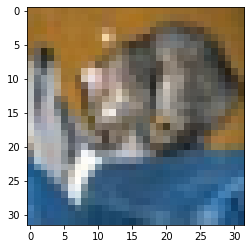

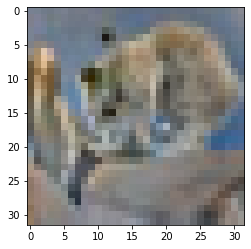

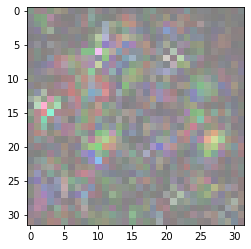

Image and Score tensor(-0.0731, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(0.1390, device='cuda:0')
Gradient and Image tensor(0.2000, device='cuda:0', grad_fn=<DivBackward0>)


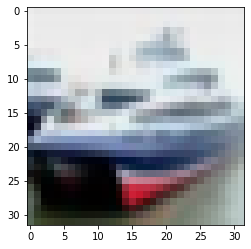

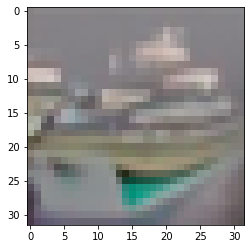

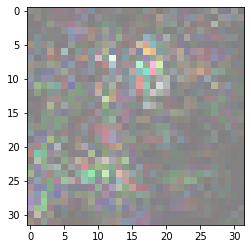

Image and Score tensor(-0.1032, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(-0.1079, device='cuda:0')
Gradient and Image tensor(0.0144, device='cuda:0', grad_fn=<DivBackward0>)


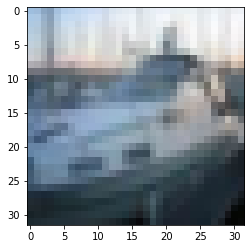

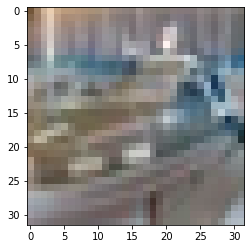

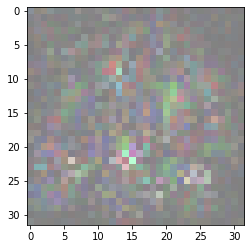

Image and Score tensor(0.0403, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(0.1700, device='cuda:0')
Gradient and Image tensor(0.3063, device='cuda:0', grad_fn=<DivBackward0>)


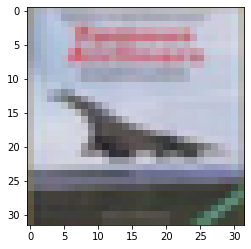

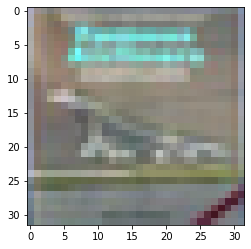

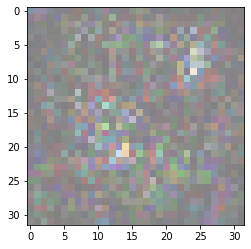

Image and Score tensor(-0.5015, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(-0.1669, device='cuda:0')
Gradient and Image tensor(-0.3383, device='cuda:0', grad_fn=<DivBackward0>)


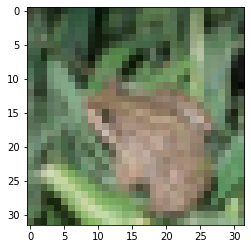

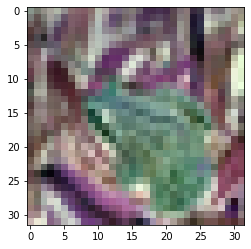

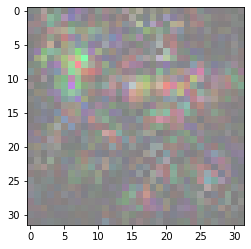

Image and Score tensor(-0.1693, device='cuda:0', grad_fn=<DivBackward0>)
Gradient and Score tensor(-0.1605, device='cuda:0')
Gradient and Image tensor(-0.3614, device='cuda:0', grad_fn=<DivBackward0>)


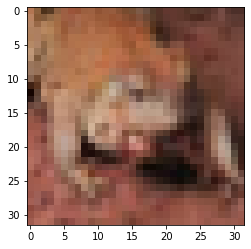

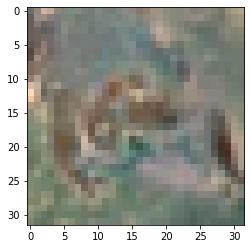

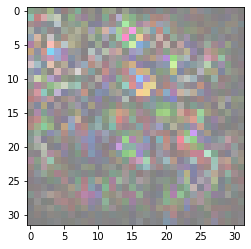

In [10]:
saliency = Saliency(model)
testloader_batch_size_1 = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

images = iter(testloader_batch_size_1).__next__()[0]
print(images.min(), images.max())

for idx, (img, label) in enumerate(iter(testloader_batch_size_1)):
    img = img.to(device)
    img.requires_grad = True

    gradient = saliency.attribute(img, target=label.item())
    gradient = gradient / gradient.max()

    score = torch.load(f'data/cifar10-test-scores/score{idx}.pt')
    score = score / score.abs().max()
    score = score.to(torch.float32)

    print( 'Image and Score', torch.inner(score.flatten(), img.flatten()) / torch.linalg.vector_norm(score.flatten()) / torch.linalg.vector_norm(img.flatten()) )

    print( 'Gradient and Score', torch.inner(score.flatten(), gradient.flatten()) / torch.linalg.vector_norm(score.flatten()) / torch.linalg.vector_norm(gradient.flatten()) )

    print( 'Gradient and Image', torch.inner(img.flatten(), gradient.flatten()) / torch.linalg.vector_norm(img.flatten()) / torch.linalg.vector_norm(gradient.flatten()) )


    img = (img * 127.5 + 128).clip(0, 255).to(torch.uint8)
    plt.imshow(img.cpu().numpy().squeeze().transpose((1,2,0)))
    plt.show()

    score = (score * 127.5 + 128).clip(0, 255).to(torch.uint8)
    plt.imshow(score.cpu().numpy().squeeze().transpose((1,2,0)))
    plt.show()

    gradient = (gradient * 127.5 + 128).clip(0, 255).to(torch.uint8)
    plt.imshow(gradient.cpu().numpy().squeeze().transpose((1,2,0)))
    plt.show()
    
    if idx == 5:
        break

In [67]:
img.dtype, score.dtype

(torch.float32, torch.float64)